<a href="https://colab.research.google.com/github/marinaepitropaki/Data_Visualization/blob/master/Photometry_one_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import glob
from google.colab import drive
from google.colab import files
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


In [ ]:
def load_data(file_path):
  """ function for loading a single file"""
  print('\nfile name:', file_path)
  hdu_list = fits.open(file_path)
  hdu = hdu_list[0]
  data = hdu.data
  hdr = hdu.header

  print('Time in JD:', hdr['JD'])
  return data, hdr

In [ ]:
def cropping(data, X_SIZE_BOX, Y_SIZE_BOX, center_x, center_y):
  """Cropping one image depending on the center of the subject
      data:
        data array as loaded aboved
      SIZE_BOX:
        constant: pixels of the crop
      center_x, center_y:
        center of the object
  """
  cropped = data[
      int((center_x - (X_SIZE_BOX/2))): int((center_x + (X_SIZE_BOX/2)))+1,
      int((center_y - (Y_SIZE_BOX/2))): int((center_y + (Y_SIZE_BOX/2)))+1
      ]
  print(cropped.shape)
  return cropped

In [ ]:
def gauss(x, H, A, x0, sigma, **kwargs):
  """ Gauss equation calculation"""
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [ ]:
def gauss_fit(x, y):
  """Calculation of the gauss parameters and fitting of the Gauss curve
      x: horizontical/ vertical pixel number
      y: horizontical/ vertical pixel value
      Return: Dictionary with the gauss parameters
  """
  mean = sum(x * y) / sum(y)
  sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
  popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
  H, A, x0, sigma = popt
  FWHM = 2.35482 * sigma #constant value from the gauss definition

  gauss_dict = {
    'H' : H,
    'A' : A,
    'x0': x0,
    'sigma': sigma,
    'FWHM': FWHM
  }
  return gauss_dict

In [ ]:
def find_max(cropped, y_pixel_box, x_pixel_box):
  """ Finds the max of the pixel value in the cropped picture"""
  if max(cropped[:,(y_pixel_box//2)])> max(cropped[(x_pixel_box//2),:]):
    max_y=max(cropped[:,(y_pixel_box//2)])
  else:
    max_y=max(cropped[(x_pixel_box//2),:])
  print(max_y)
  return max_y

In [ ]:
def create_bkg_image(cropped, x_x0, y_x0, XFWHM, YFWHM, BKG_FWHM):

  """Masks the pixels covered by the object to create a background image
  x_x0, y_x0: horizontical and vertical x0
  XFWHM,YFWHM:horizontical and vertical FWHM
  BGK_FWHM: resizing window parameter
  Returns: masked area
  """
  bkg = cropped.copy()
  bkg[int((x_x0 - XFWHM*BKG_FWHM)): int((x_x0 + XFWHM*BKG_FWHM))+1,
      int((y_x0 - YFWHM*BKG_FWHM)): int((y_x0 + YFWHM*BKG_FWHM))+1] = 0
  return bkg

In [ ]:
def get_gauss_plotting_data(pixel_number,
                            gauss_params_dict,
                            gauss_plot_points=100):
  """ Calculating the gauss data to plot
    pixel_number: horizontical or vertical, number of pixels
    gauss_params_dict: gauss dictionary
    Returns: the data that will be plotted in the gauss curve
  """
  gauss_data_x = np.linspace(pixel_number.min(), 
                              pixel_number.max(), 
                              gauss_plot_points
                              )
  gauss_data_y = gauss(gauss_data_x, **gauss_params_dict) 

  return gauss_data_x, gauss_data_y

In [ ]:
def show_results( h_pixel_number, 
                  h_pixel_value,
                  horizontal_gauss_params_dict,
                  v_pixel_number, 
                  v_pixel_value,
                  vertical_gauss_params_dict,
                  cropped,
                  star_aperture_crop ,
                  gauss_plot_points=100):
  """Plotting the Gauss data, real data and Showing the pixel crops"""
  
  gauss_hdata_x, gauss_hdata_y = get_gauss_plotting_data(h_pixel_number, 
                                                         horizontal_gauss_params_dict)
   
  gauss_vdata_x, gauss_vdata_y = get_gauss_plotting_data(v_pixel_number, 
                                                         vertical_gauss_params_dict )
  
  fig, ax = plt.subplots(1, 4, figsize=(20, 10) )


  ax[0].plot(h_pixel_value , )
             
  ax[0].plot(gauss_hdata_x, gauss_hdata_y , '--r', 
             label='fit')
  
  ax[0].set_ylim(0, max_y*1.1)
  ax[0].set_xlabel('Pixel Number')
  ax[0].set_ylabel('Pixel Value')
  ax[0].set_title(f'FWHM:{np.round(horizontal_gauss_params_dict["FWHM"], 2)}')

  ax[1].plot(v_pixel_value , marker='o', linestyle='dashed')
             
  ax[1].plot(gauss_vdata_x, gauss_vdata_y , '--r',  label='fit')
  
  ax[1].set_ylim(0, max_y*1.1)
  ax[1].set_xlabel('Pixel Number')
  ax[1].set_ylabel('Pixel Value')
  ax[1].set_title(f'FWHM:{np.round(vertical_gauss_params_dict["FWHM"], 2)}')
  ax[1].yaxis.set_major_locator(plt.NullLocator())

 
  ax[2].imshow(cropped)
  ax[2].set_xlabel('Pixel Number')
  ax[2].set_ylabel('Pixel Number')

  ax[3].imshow(star_aperture_crop)
  ax[3].set_xlabel('Pixel Number')
  ax[3].set_ylabel('Pixel Number')

  plt.subplots_adjust(wspace=0.1, hspace=10, top=0.95, bottom=0.6)

  # uncoment and select the name to save the plot
  # plt.savefig(f"{images_path}/stacked_r.png")
  plt.show()



In [ ]:
drive.mount('/content/drive')
#Path for the aligned images
image_path = '/content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned'
images_dir = '/content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per*.fit'


In [ ]:
photometry_files = sorted(glob.glob(images_dir))[:30]
photometry_files


In [ ]:
BKG_FWHM = 2 #resizing parameter for the background
FWHM_RESIZING_PARAMETER = 1.5 #resizing parameter for the cropped subject plot
X_SIZE_BOX = 20 #pixel number x axis
Y_SIZE_BOX = 20 #pixel number y axis

time_list=[]
star_aperture_data_list = []
bkg_data_list = []
star_pixel_sum_list = []
bkg_pixel_sum_list = []
star_pixel_nobkg_list = []
bkg_area = []
bkg_area_reduced = []
star_pixel_area = []
bkg_mean_list = []

#for NVS ALIGNED, NONE filter
center_y = 664.49056
center_x = 617.50944

# #for g fiter
# center_y = 420.97004
# center_x = 445.88645
# max_y = 0

# #for stacked g filter
# center_y = 420.83796
# center_x =445.92778


# #for stacked i filter
# center_y = 424.58693
# center_x = 447.65471


# #for stacked r filter
# center_y = 422.4822
# center_x = 446.99858


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-001_40.fit
Time in JD: 2459164.523888889
(21, 21)
39128.91707059994
(5, 5)


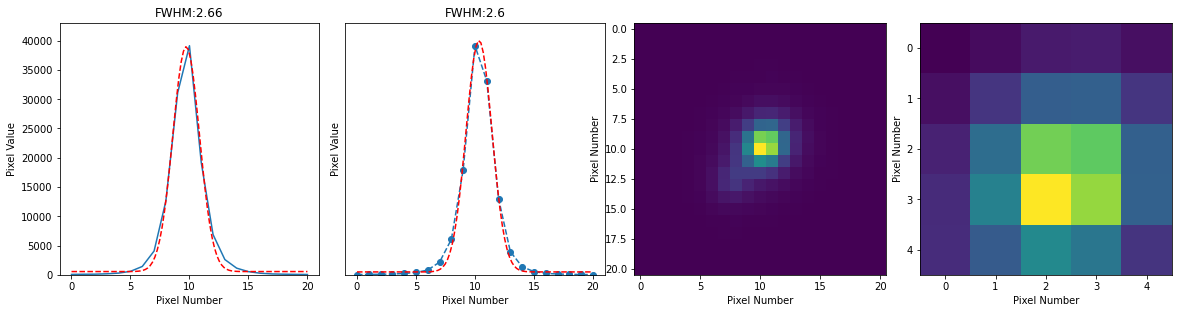


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-002_40.fit
Time in JD: 2459164.524386574
(21, 21)
39331.803540579735
(5, 5)


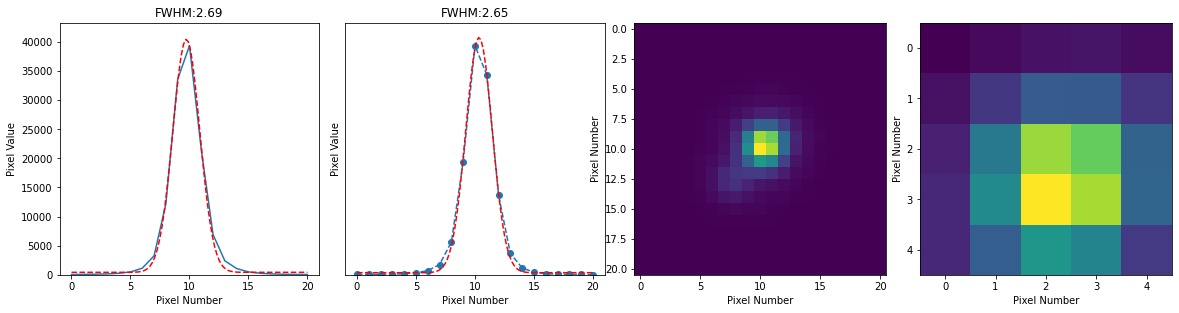


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-003_40.fit
Time in JD: 2459164.5248958333
(21, 21)
36642.48407838352
(5, 5)


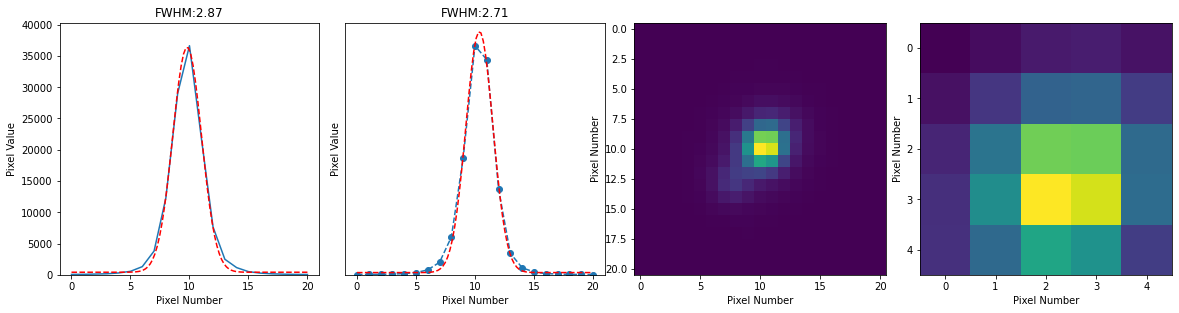


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-004_40.fit
Time in JD: 2459164.5254050926
(21, 21)
33598.2530335955
(6, 5)


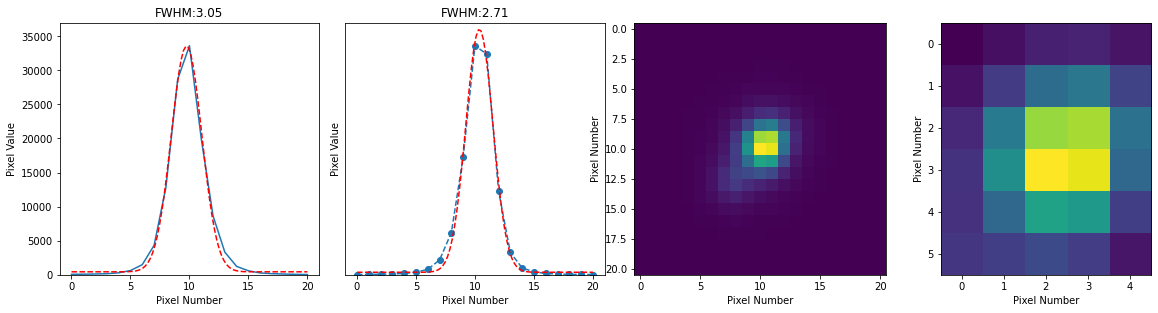


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-005_40.fit
Time in JD: 2459164.525914352
(21, 21)
33207.48965665337
(5, 5)


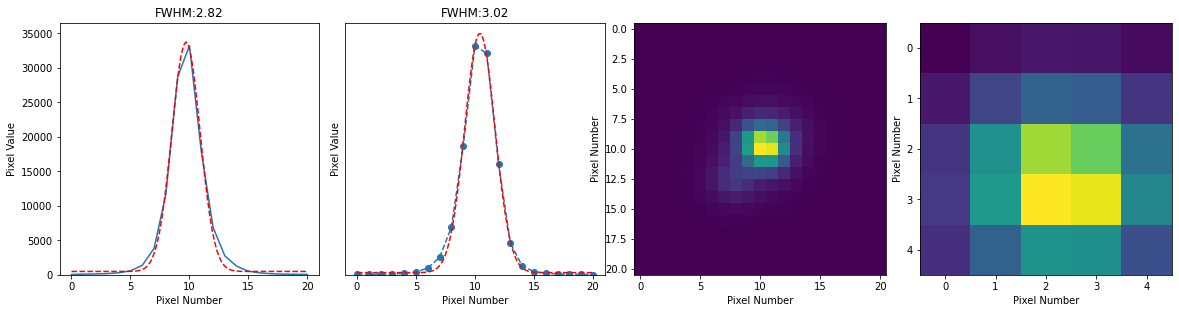


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-006_40.fit
Time in JD: 2459164.526412037
(21, 21)
25771.802337837267
(6, 7)


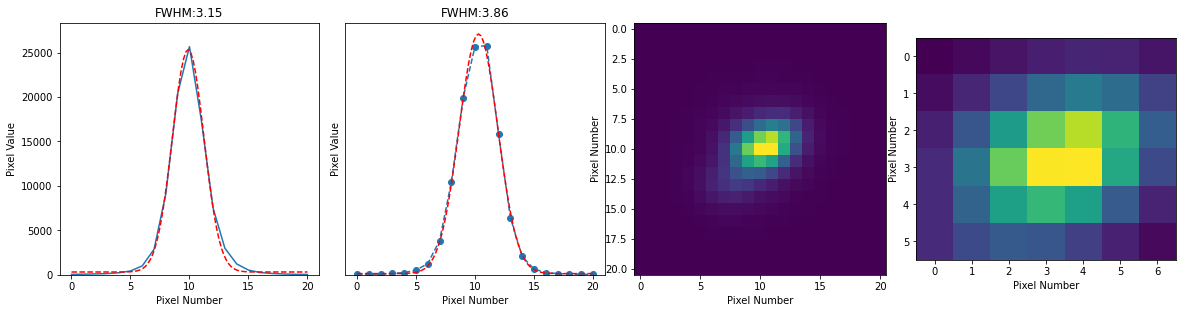


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-007_40.fit
Time in JD: 2459164.5269212965
(21, 21)
39774.643134234546
(5, 5)


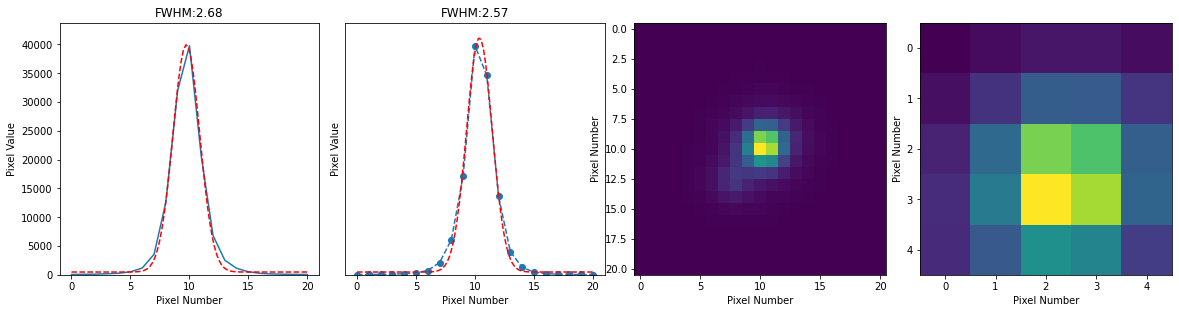


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-008_40.fit
Time in JD: 2459164.527430556
(21, 21)
32207.53117655411
(5, 5)


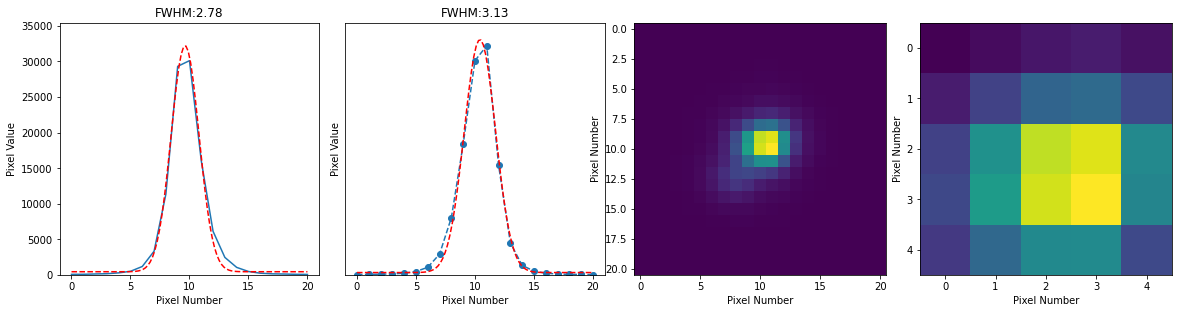


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-009_40.fit
Time in JD: 2459164.5279282406
(21, 21)
33257.507722626884
(5, 5)


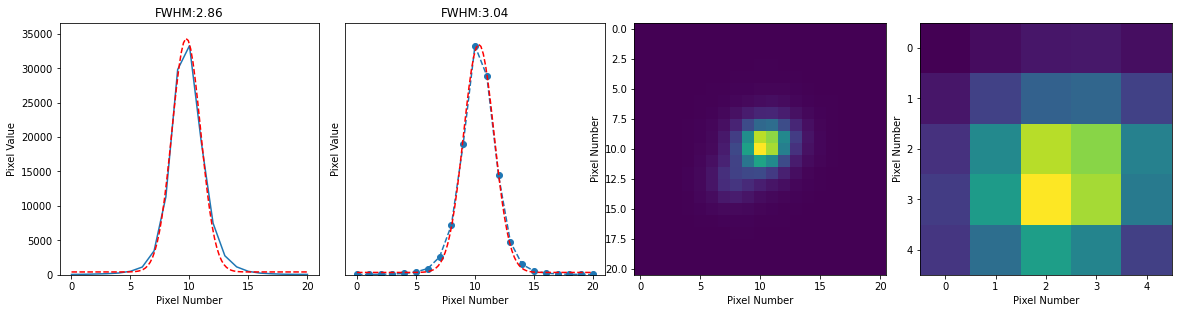


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-010_40.fit
Time in JD: 2459164.5284375
(21, 21)
40721.80795663071
(5, 5)


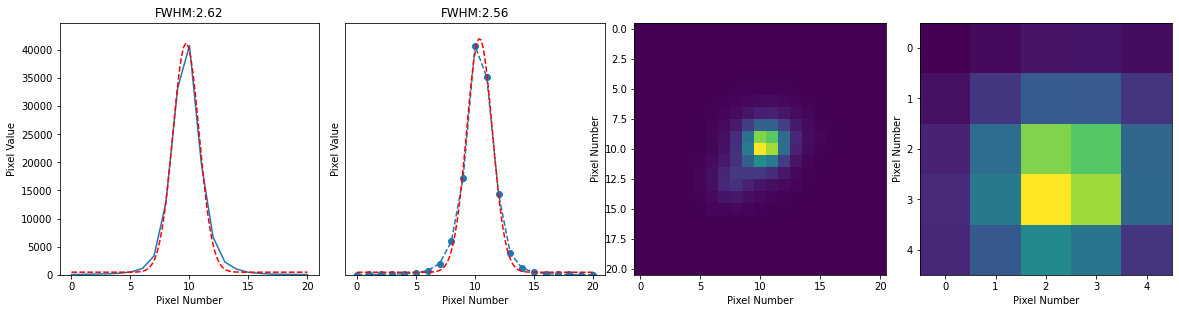


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-011_40.fit
Time in JD: 2459164.528946759
(21, 21)
33786.388249999036
(5, 5)


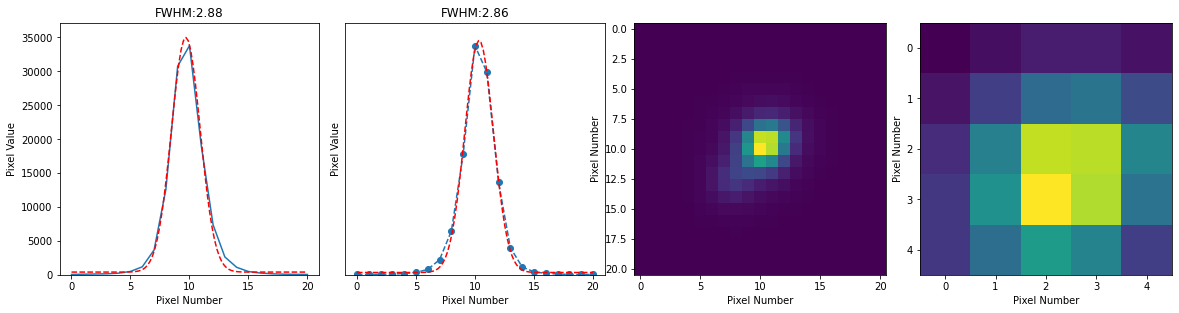


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-012_40.fit
Time in JD: 2459164.5294444445
(21, 21)
38081.19040268289
(5, 5)


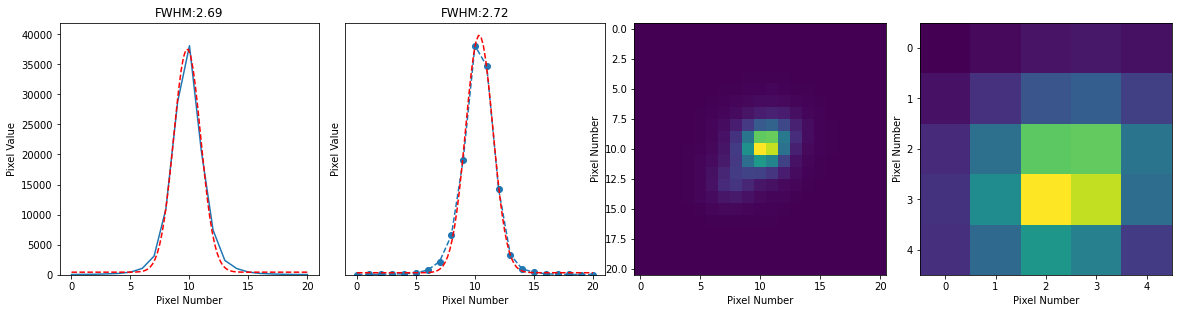


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-013_40.fit
Time in JD: 2459164.5299537037
(21, 21)
34873.19686780089
(5, 5)


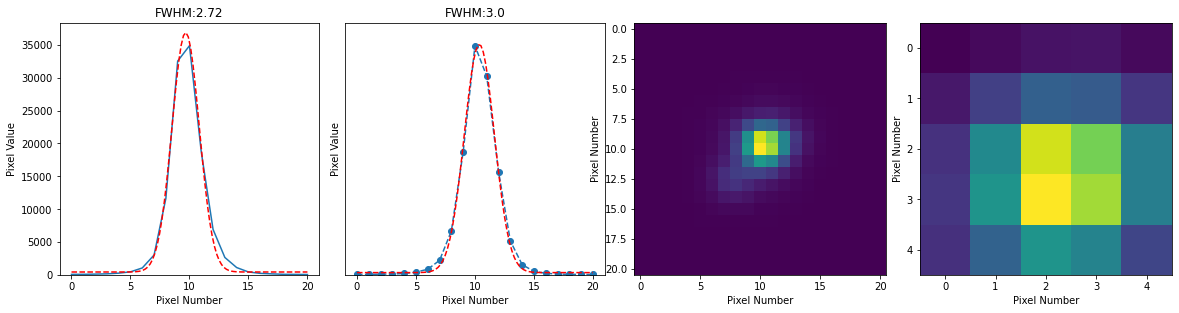


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-014_40.fit
Time in JD: 2459164.530462963
(21, 21)
32462.033667049396
(5, 5)


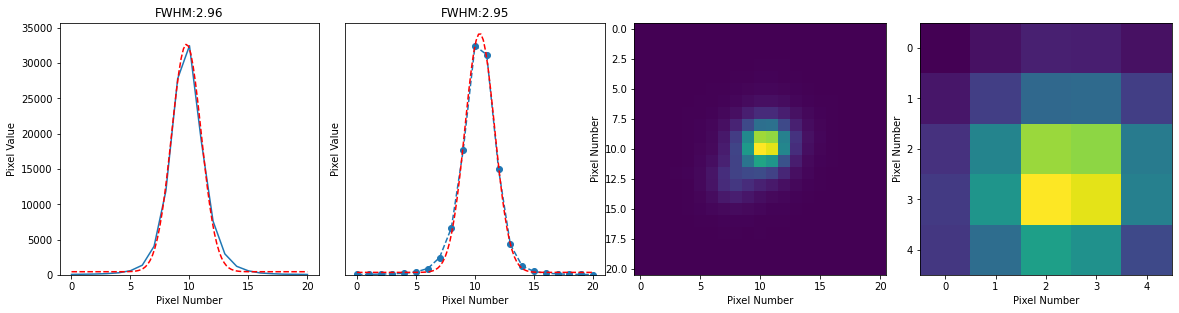


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-015_40.fit
Time in JD: 2459164.5309606483
(21, 21)
36175.49565758065
(5, 5)


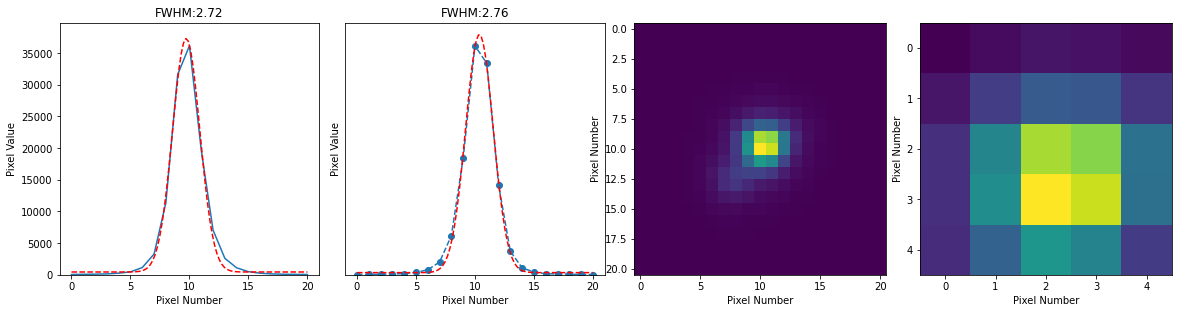


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-016_40.fit
Time in JD: 2459164.5314699076
(21, 21)
32037.04023533825
(5, 5)


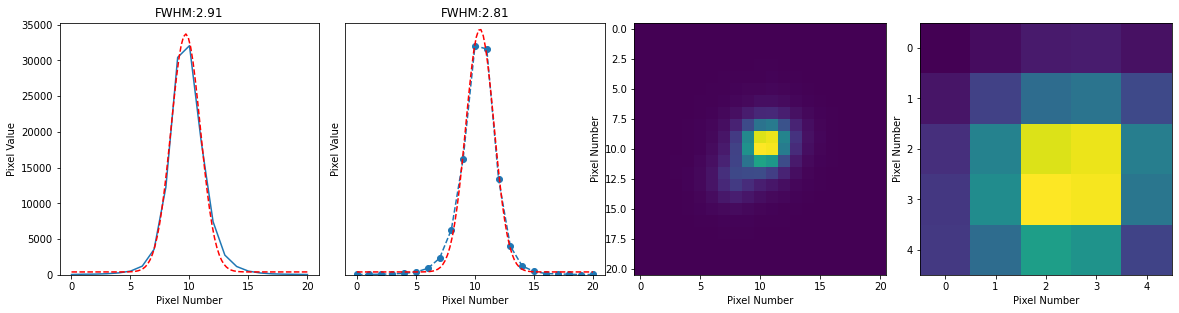


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-017_40.fit
Time in JD: 2459164.531979167
(21, 21)
32257.927265180704
(6, 5)


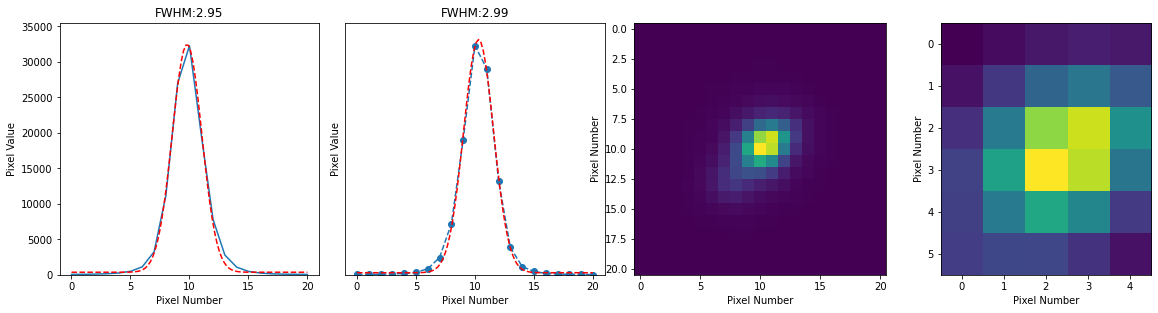


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-018_40.fit
Time in JD: 2459164.5324884257
(21, 21)
38960.93624338209
(5, 5)


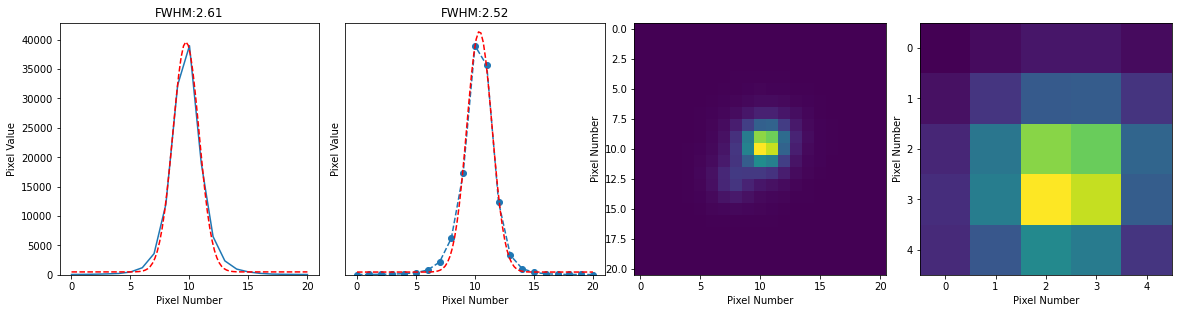


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-019_40.fit
Time in JD: 2459164.532986111
(21, 21)
34378.30998098613
(5, 5)


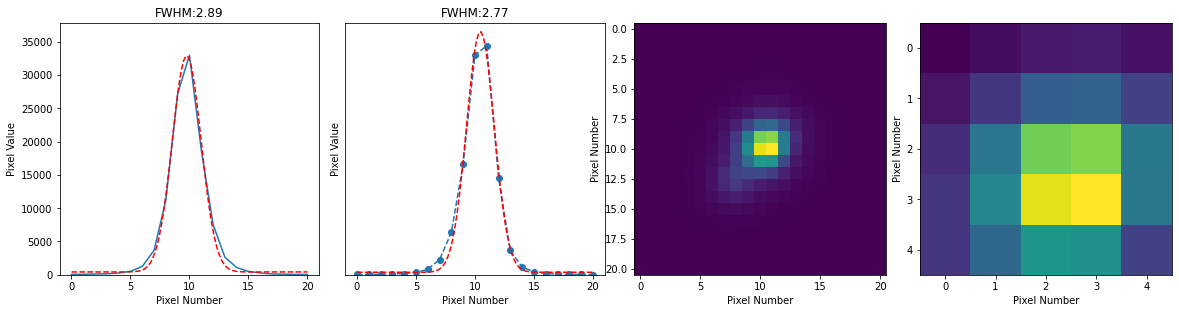


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-020_40.fit
Time in JD: 2459164.5334953703
(21, 21)
37932.3141085211
(5, 5)


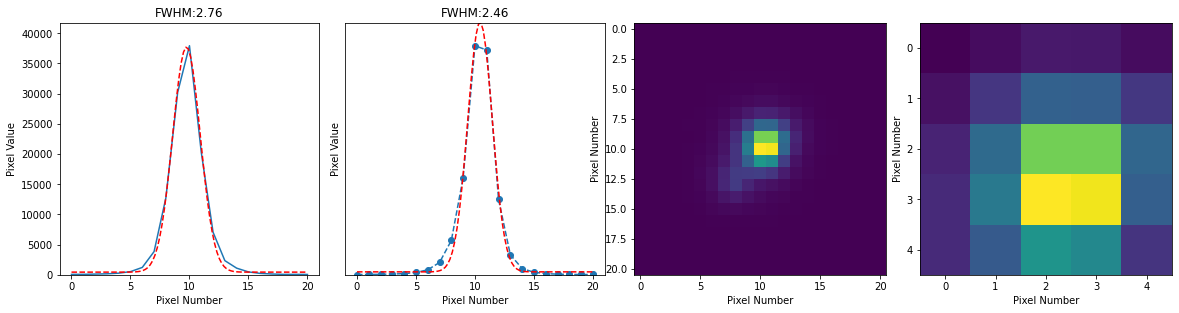


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-021_40.fit
Time in JD: 2459164.5340046296
(21, 21)
34110.15809729533
(5, 5)


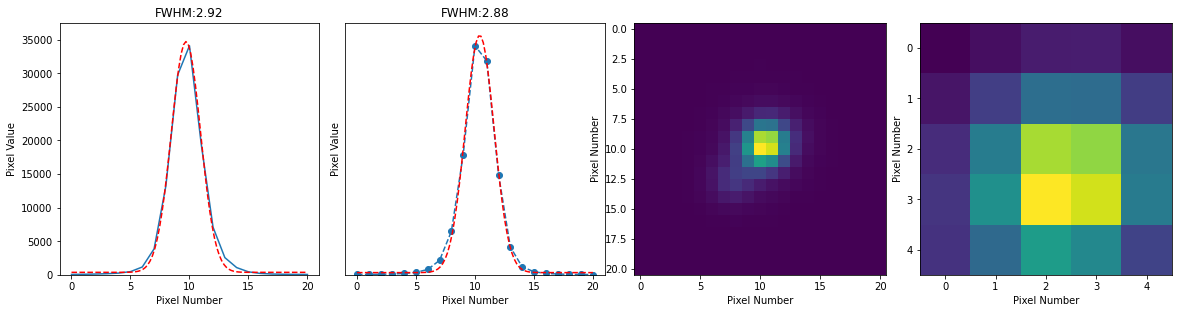


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-022_40.fit
Time in JD: 2459164.534513889
(21, 21)
33163.17992719271
(5, 5)


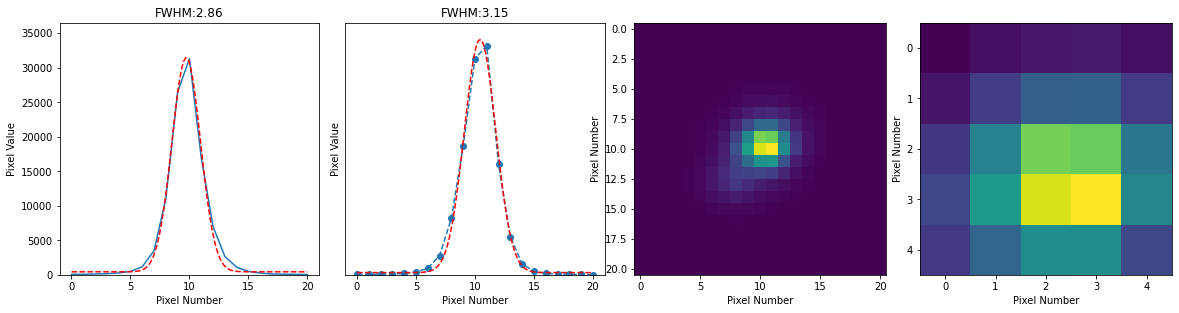


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-023_40.fit
Time in JD: 2459164.535011574
(21, 21)
34718.180189799576
(5, 5)


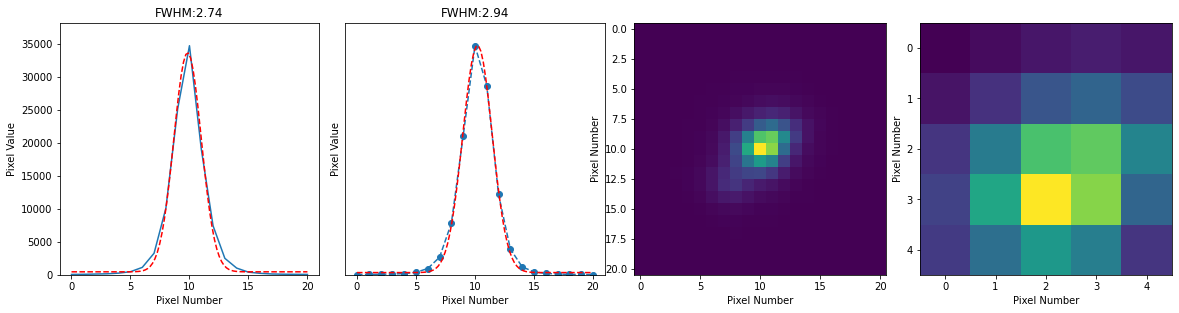


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-024_40.fit
Time in JD: 2459164.5355208335
(21, 21)
34331.949489315404
(5, 5)


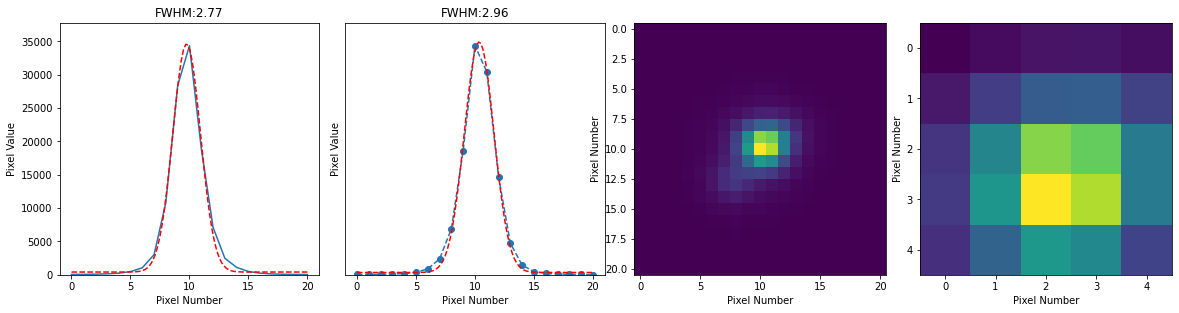


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-025_40.fit
Time in JD: 2459164.5360300927
(21, 21)
37419.22286079229
(5, 5)


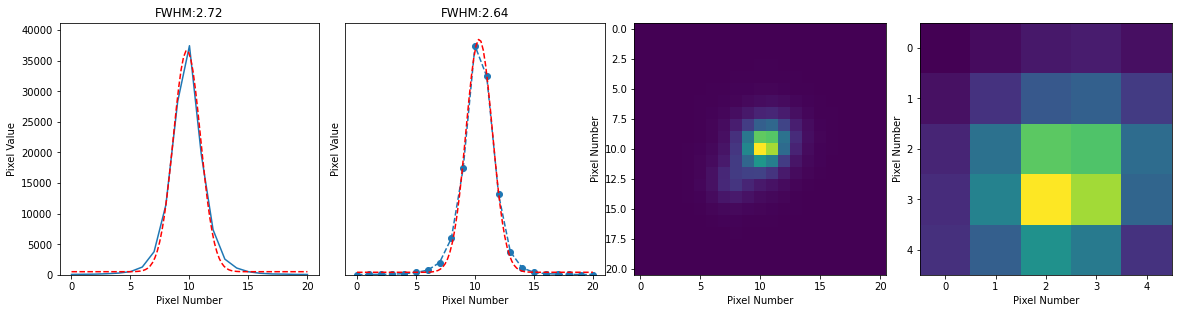


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-026_40.fit
Time in JD: 2459164.5365277776
(21, 21)
35310.575142194044
(5, 5)


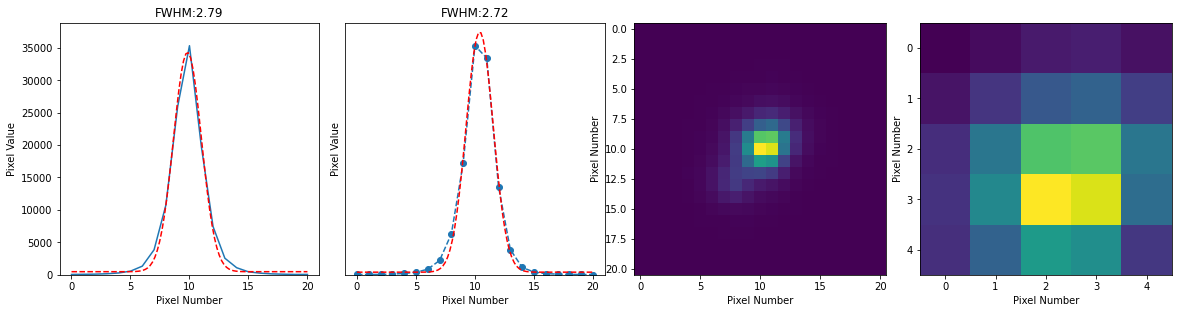


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-027_40.fit
Time in JD: 2459164.537037037
(21, 21)
37717.23374438908
(5, 5)


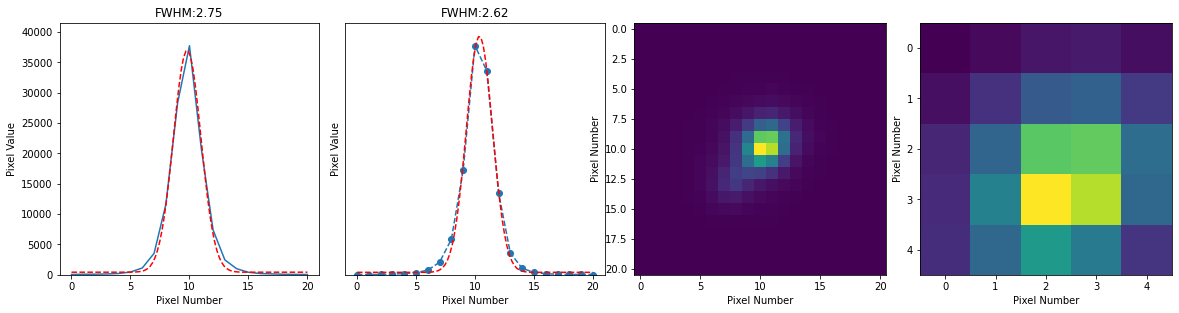


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-028_40.fit
Time in JD: 2459164.537546296
(21, 21)
28479.86019874953
(5, 6)


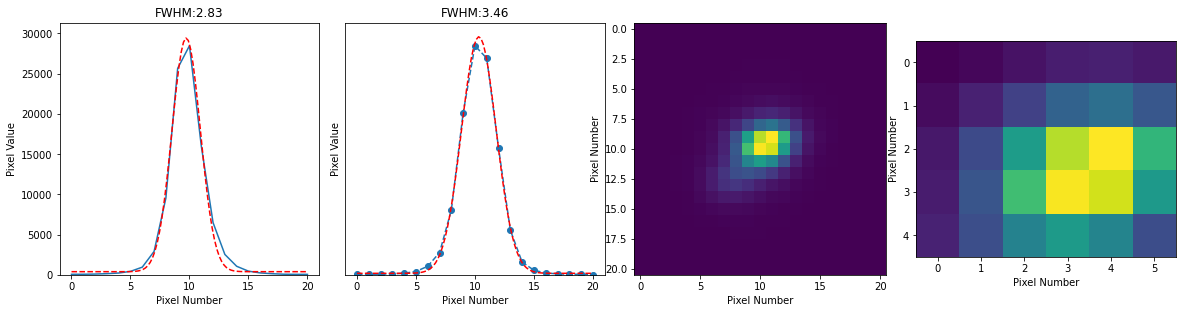


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-029_40.fit
Time in JD: 2459164.5380439814
(21, 21)
33397.90491883288
(5, 5)


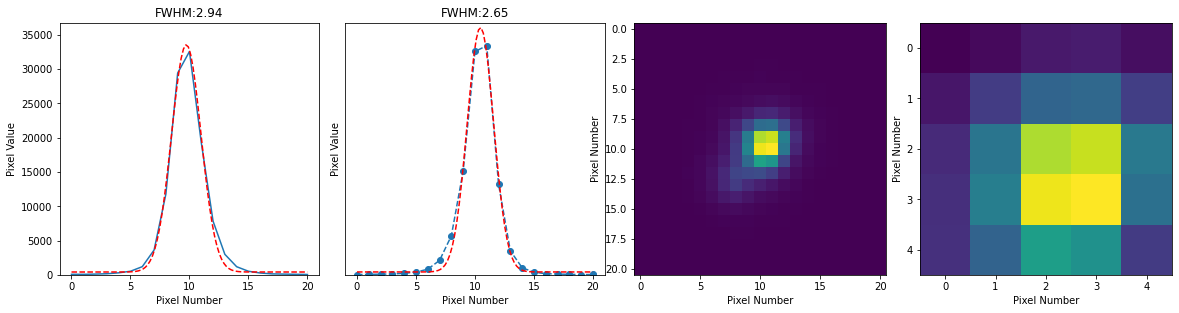


file name: /content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/v432per-R-030_40.fit
Time in JD: 2459164.5385532407
(21, 21)
28087.196789623085
(5, 5)


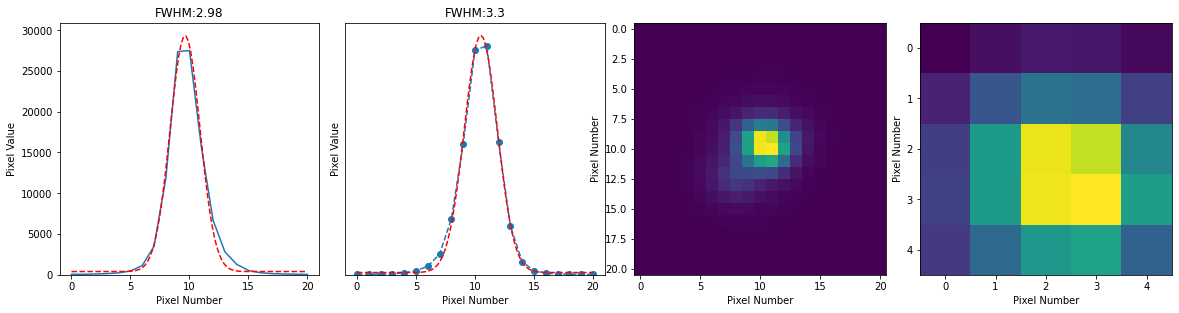

In [ ]:
#Results for each one of the files

for f in photometry_files:

  data, hdr = load_data(f)
  time_list.append(hdr['JD'])

  #Cropping the main image

  cropped = cropping(data, X_SIZE_BOX, Y_SIZE_BOX, center_x, center_y)
 
  max_y = find_max(cropped, Y_SIZE_BOX, X_SIZE_BOX)

  #horizontal parameters
  h_pixel_value = cropped[:,(Y_SIZE_BOX//2)]
  h_pixel_number = np.array(list(range(len(h_pixel_value))))
  
  horizontal_gauss_params_dict =  gauss_fit(
      h_pixel_number,
      h_pixel_value
      )

  #vertical parameters
  v_pixel_value = cropped[(Y_SIZE_BOX//2),:]
  v_pixel_number = np.array(list(range(len(v_pixel_value))))
  
  vertical_gauss_params_dict =  gauss_fit(
      v_pixel_number,
      v_pixel_value
      ) 
  
  #Cropping an even smaller area that contains only the object closely, using the gauss parameters

  star_cropping_hsize = horizontal_gauss_params_dict['FWHM'] * FWHM_RESIZING_PARAMETER
  star_cropping_vsize = vertical_gauss_params_dict['FWHM']*FWHM_RESIZING_PARAMETER
  star_aperture_crop = cropping(cropped,
                                star_cropping_hsize,
                                star_cropping_vsize,
                                horizontal_gauss_params_dict['x0'],
                                vertical_gauss_params_dict['x0']
                                )
  star_aperture_data_list.append(star_aperture_crop)

  #Masking the second crop in order to calculate the background
  bkg = create_bkg_image(cropped, horizontal_gauss_params_dict['x0'], 
                         vertical_gauss_params_dict['x0'],  
                         horizontal_gauss_params_dict['FWHM'], 
                         vertical_gauss_params_dict['FWHM'], BKG_FWHM)
  bkg_data_list.append(bkg) 

  show_results( h_pixel_number, 
                h_pixel_value,
                horizontal_gauss_params_dict,
                v_pixel_number, v_pixel_value,
                vertical_gauss_params_dict,
                cropped,
                star_aperture_crop)


In [ ]:
#Creation of a list with data from the second crop to reduce the background

for star_data, bkg_data in zip(star_aperture_data_list, bkg_data_list):

  star_pixel_area = star_data.size
  star_pixel_sum = np.sum(star_data)
  star_pixel_sum_list.append(star_pixel_sum)

  #size calculation to reduce
  bkg_area = bkg_data.size
  bkg_area_reduced = bkg_area - star_pixel_area    

  bkg_pixel_sum = np.sum(bkg_data)
  #calculating the mean background value
  bkg_mean = bkg_pixel_sum/bkg_area_reduced
  bkg_mean_list.append(bkg_mean)
  
  #Reducing the background from the object
  star_pixel_nobkg = star_pixel_sum - bkg_mean
  star_pixel_nobkg_list.append(star_pixel_nobkg)

In [ ]:
len(star_pixel_nobkg_list)

Text(0, 0.5, 'Intensity')

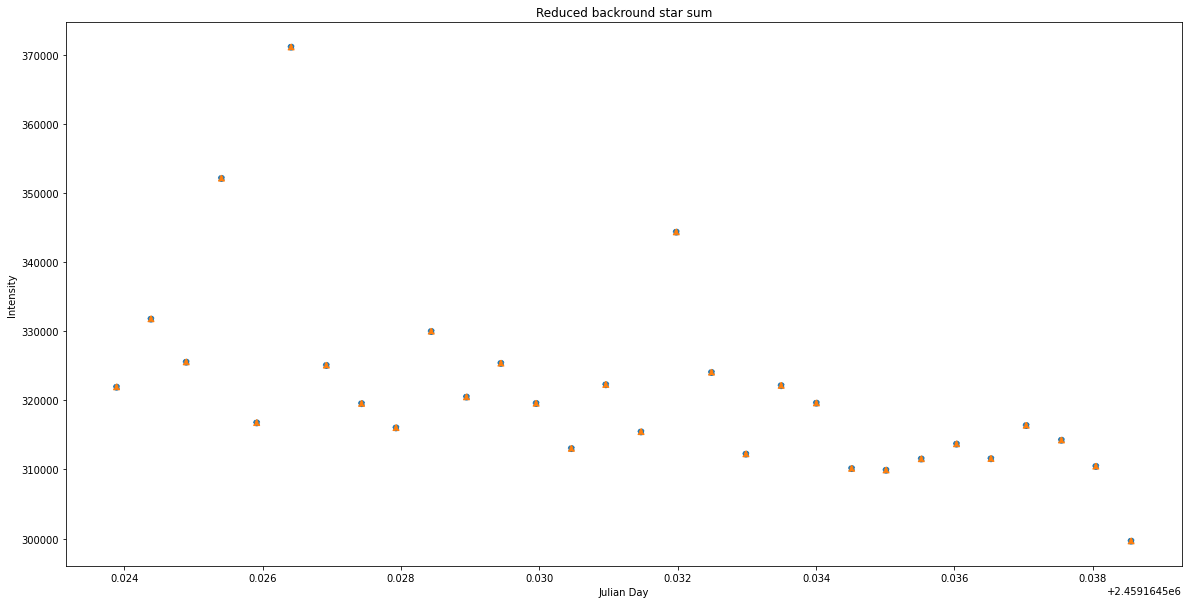

In [ ]:
#Comparison Plots
fig = plt.figure(figsize=(20,10))
plt.scatter(time_list, star_pixel_nobkg_list,marker='o', linestyle='dashed' )
#plt.scatter(time_list, bkg_mean_list,marker='o', linestyle='dashed', color='r')
plt.scatter(time_list, star_pixel_sum_list,marker='^', linestyle='dashed')

plt.title('Reduced backround star sum')
plt.xlabel('Julian Day')
plt.ylabel('Intensity')